In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [9]:
df = pd.read_csv("../Data/final_cleaned_dataset.csv")
df.head(10)

,Unnamed: 0,CountryName,CountryCode,TourismEmploymentPer1000,FoodEmploymentPer1000,TourismGDPPercentage,BusinessToPersonalRatio,AverageStayDays,InboundArrivalsPer1000,DomesticTouristsPer1000,...,ReverseTrafficInefficiencyIndex,ReverseTrafficIndex,CostOfLivingIndex,GroceriesCostIndex,RestaurantPriceIndex,SafetyIndex,HealthCareIndex,ClimateIndex,ReverseTrafficTimeIndexMinutes,ReversePollutionIndex
0,0,Albania,ALB,7.504031,4.193368,44.309331,0.717118,5.944768,39.702955,8.398225,...,88.344563,81.982530,39.900000,40.400000,38.200000,55.3,48.200000,86.400000,28.600000,16.70000
1,1,Algeria,DZA,3.332237,5.124792,7.379125,100.000000,1.448045,7.447736,16.461942,...,65.897338,62.508253,24.500000,33.200000,14.500000,47.4,54.500000,78.983509,24.495389,29.80000
2,2,Angola,AGO,0.801504,0.792118,20.819858,5.852092,12.811064,12.904143,9.473684,...,51.453717,46.192311,29.264344,33.048663,25.126312,33.7,59.307193,79.035177,18.610040,23.20854
3,3,Argentina,ARG,13.948049,16.904949,12.635763,7.492798,5.894817,13.120387,12.509640,...,66.310146,59.383349,35.700000,37.000000,39.800000,36.6,68.000000,98.300000,21.500000,42.90000
4,4,Australia,AUS,10.484332,11.472232,10.437995,15.453747,4.291437,16.573270,61.214070,...,54.180872,63.999986,60.900000,67.900000,59.200000,52.7,73.400000,93.800000,27.900000,66.90000
5,5,Austria,AUT,8.868858,16.934024,21.469656,9.769292,11.028254,35.656234,23.397471,...,95.818678,95.795208,60.700000,62.200000,59.700000,70.5,77.900000,77.800000,41.500000,72.80000
6,6,Azerbaijan,AZE,2.179634,6.713445,25.135148,18.031400,1.012338,14.275581,20.529080,...,64.448083,64.335064,29.500000,28.300000,33.100000,68.2,48.300000,91.400000,24.700000,21.00000
7,7,Bahrain,BHR,23.746328,46.659039,15.089001,2.996084,7.835692,33.718150,2.354149,...,75.242105,75.164129,48.300000,46.200000,47.600000,75.5,59.609521,79.485780,33.110632,22.10000
8,8,Belarus,BLR,12.782898,10.862407,10.559535,15.482871,5.080287,14.116552,5.648023,...,90.879038,82.987765,25.000000,24.700000,27.500000,50.2,48.500000,64.400000,34.100000,48.80000
9,9,Belgium,BEL,6.063175,9.376712,12.710966,26.371360,10.280533,17.154838,12.273218,...,69.517033,73.680030,56.500000,54.600000,67.100000,50.6,75.900000,86.000000,30.500000,44.50000


In [11]:
# 3. Determine Optimal Number of Clusters Using the Silhouette Methodfrom sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import StandardScaler


X = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

min_samples = 5
best_eps = None
best_score = -1
best_n_clusters = None
scores = []
eps_values = np.arange(0.5, 5.0, 0.1)

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)

    # Count clusters excluding noise
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Only compute silhouette if there are >1 cluster
    if n_clusters > 1:
        mask = labels != -1
        score = silhouette_score(X_scaled[mask], labels[mask])
        scores.append((eps, score, n_clusters))
        if score > best_score:
            best_score = score
            best_eps = eps
            best_n_clusters = n_clusters
    else:
        scores.append((eps, -1, n_clusters))

print(f"Best eps: {best_eps}")
print(f"Best silhouette score: {best_score}")
print(f"min_samples: {min_samples}")
print(f"Number of clusters: {best_n_clusters}")


Best eps: 2.3
Best silhouette score: 0.3143271797783923
min_samples: 5
Number of clusters: 2


In [12]:
# 4. Apply DBSCAN Clustering
# The concept of Tourism-Heavy vs. Tourism-Light countries refers to the distinction between countries based on the intensity of 
# tourism activities within their economy. It is typically used to categorize countries that have significant levels of tourism-related 
# economic activity (Tourism-Heavy) versus those where tourism plays a smaller or less significant role (Tourism-Light).

tourism_features = [
    'TourismEmploymentPer1000',
    'FoodEmploymentPer1000',
    'TourismGDPPercentage',
    'InboundArrivalsPer1000',
    'DomesticTouristsPer1000',
    'AverageStayDays',
    'BusinessToPersonalRatio'
]

# 1. Select and scale features
X = df[tourism_features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Apply DBSCAN using known best parameters
db = DBSCAN(eps=2.3, min_samples=5)
labels = db.fit_predict(X_scaled)

# 3. Attach cluster labels to the original dataframe
df_clusters = df.loc[X.index].copy()
df_clusters['Cluster'] = labels

# 4. Show cluster counts and sample countries
print(df_clusters['Cluster'].value_counts())
print(df_clusters[['CountryName', 'Cluster']].groupby('Cluster').head(10))

Cluster
 0    84
-1     5
Name: count, dtype: int64
       CountryName  Cluster
0          Albania        0
1          Algeria       -1
2           Angola        0
3        Argentina        0
4        Australia        0
5          Austria        0
6       Azerbaijan        0
7          Bahrain        0
8          Belarus        0
9          Belgium        0
10          Belize        0
14  Cayman Islands       -1
17         Croatia       -1
44      Madagascar       -1
49          Monaco       -1


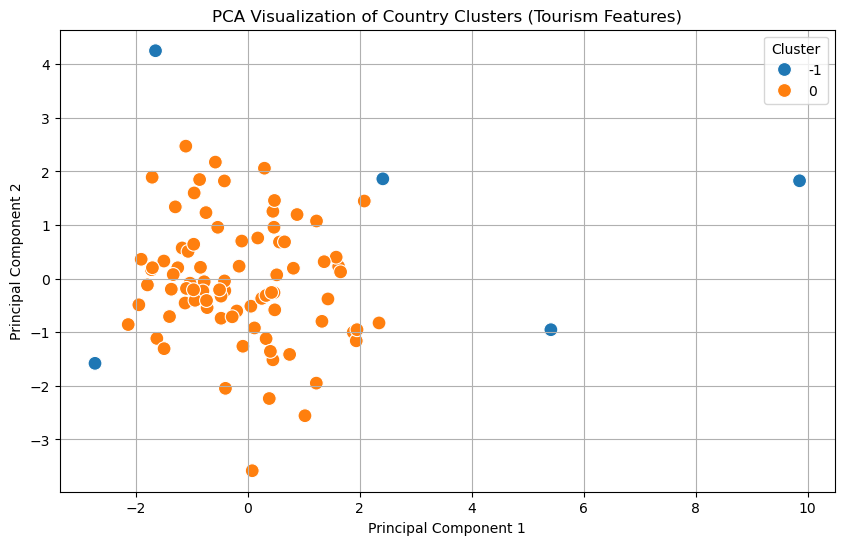

In [14]:
# 5. Interpretation Using PCA
# Apply PCA to reduce to 2 components
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to the DataFrame for easy plotting
df_clusters['PCA1'] = X_pca[:, 0]
df_clusters['PCA2'] = X_pca[:, 1]

# Plot the PCA visualization, colored by cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clusters, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title("PCA Visualization of Country Clusters (Tourism Features)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



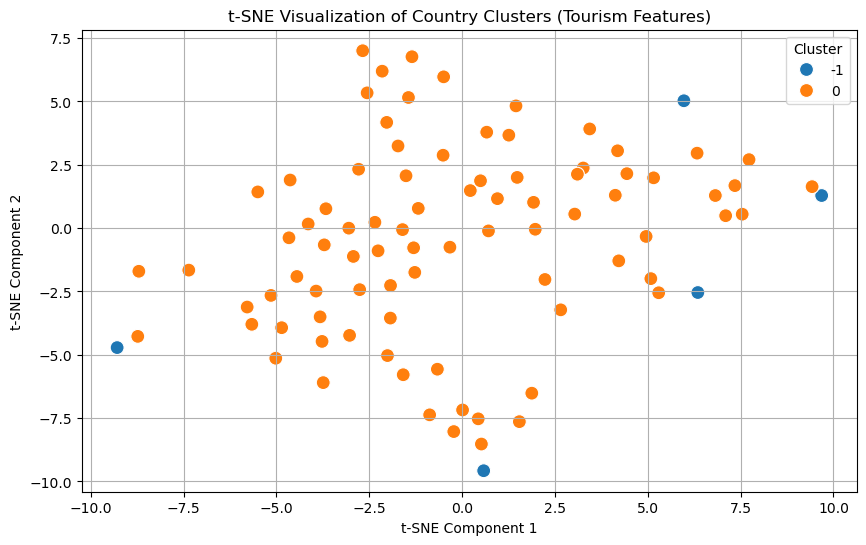

In [15]:
# 6. Interpretation Using t-SNE
# Apply t-SNE to reduce the dimensions to 2 for visualization
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

# Add t-SNE results to the DataFrame for easy plotting
df_clusters['tSNE1'] = X_tsne[:, 0]
df_clusters['tSNE2'] = X_tsne[:, 1]

# Plot the t-SNE visualization, colored by cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clusters, x='tSNE1', y='tSNE2', hue='Cluster', palette='tab10', s=100)
plt.title("t-SNE Visualization of Country Clusters (Tourism Features)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



In [16]:
# 7. Validation Metrics

from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score for your DBSCAN clustering result
score = silhouette_score(X_scaled, db.labels_)
print(f"Silhouette Score: {score}")

from sklearn.metrics import davies_bouldin_score

# Compute the Davies-Bouldin Index
dbi_score = davies_bouldin_score(X_scaled, db.labels_)
print(f"Davies-Bouldin Index: {dbi_score}")

from sklearn.metrics import calinski_harabasz_score

# Compute the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_scaled, db.labels_)
print(f"Calinski-Harabasz Index: {ch_score}")



Silhouette Score: 0.5499628950915901
Davies-Bouldin Index: 2.2217217885988463
Calinski-Harabasz Index: 9.154504779570347


In [24]:
# Cost & Infrastructure Based Clustering !!!!!!!
# Select features related to cost and infrastructure
cost_infrastructure_features = [
    'CostOfLivingIndex', 'GroceriesCostIndex', 'RestaurantPriceIndex',
    'SafetyIndex', 'HealthCareIndex', 'ClimateIndex', 
    'ReversePollutionIndex', 'ReverseTrafficIndex', 
    'ReverseTrafficInefficiencyIndex', 'ReverseTrafficTimeIndexMinutes'
]

X_cost_infrastructure = df[cost_infrastructure_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cost_infrastructure)

# Perform DBSCAN clustering
best_eps = None
best_score = -1
scores = []
eps_values = np.arange(0.2, 3.0, 0.1)
min_samples = 5  

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X_scaled)
    
    if len(set(labels)) > 1 and len(set(labels)) != 1 + (1 if -1 in labels else 0):
        score = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
        scores.append((eps, score))
        if score > best_score:
            best_score = score
            best_eps = eps
    else:
        scores.append((eps, -1))

print(f"Best eps: {best_eps}, Best Silhouette Score: {best_score}")


Best eps: 1.2000000000000004, Best Silhouette Score: 0.4138546787056724


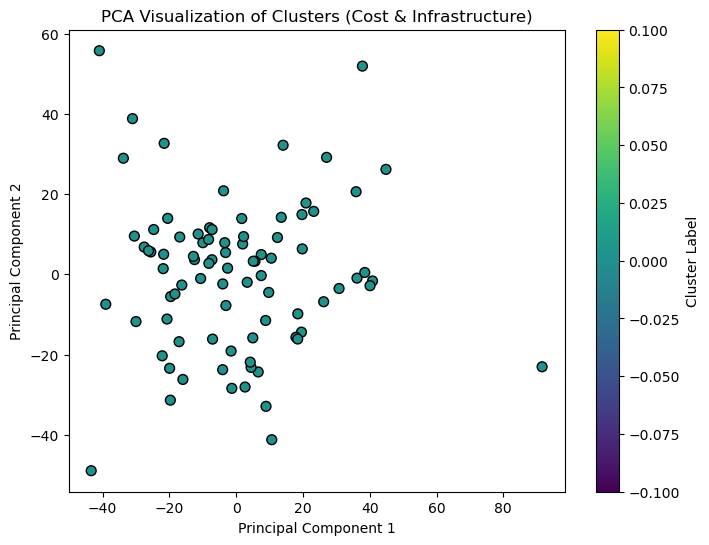

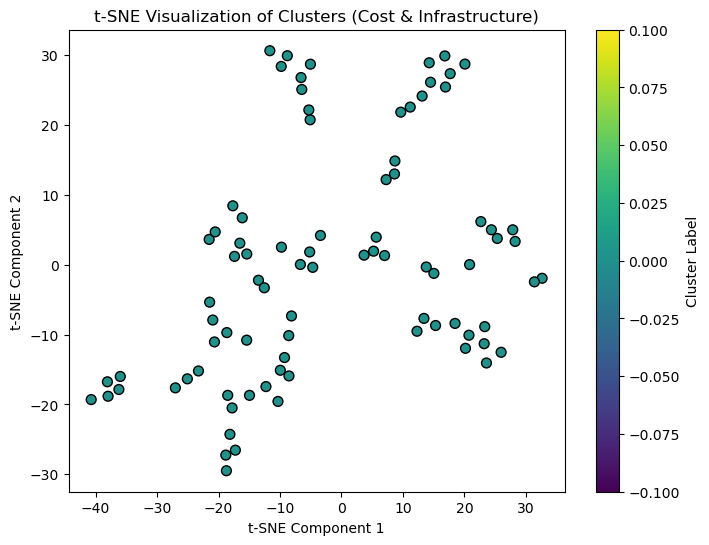

In [25]:
# Assuming you have the 'labels' from DBSCAN, create non-noise data
X_non_noise = X[labels != -1]  # Filter out noise points (label -1)
labels_non_noise = labels[labels != -1]  # Filter out noise points for the labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_non_noise)  # Using non-noise points for visualization

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_non_noise, cmap='viridis', marker='o', edgecolors='k', s=50)
plt.title('PCA Visualization of Clusters (Cost & Infrastructure)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Perform t-SNE (reduce to 2D for visualization)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # Reduce perplexity to 5
X_tsne = tsne.fit_transform(X_non_noise)  # Using non-noise points for visualization

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_non_noise, cmap='viridis', marker='o', edgecolors='k', s=50)
plt.title('t-SNE Visualization of Clusters (Cost & Infrastructure)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [26]:
# Calculate Davies-Bouldin, Calinski-Harabasz, and Dunn Index for the best clustering result
db = DBSCAN(eps=best_eps, min_samples=min_samples)
labels = db.fit_predict(X_scaled)

# Filter out noise points (-1) for validation metrics
labels_non_noise = labels[labels != -1]
X_non_noise = X_scaled[labels != -1]

# Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(X_non_noise, labels_non_noise)

# Calinski-Harabasz Index
from sklearn.metrics import calinski_harabasz_score
ch_index = calinski_harabasz_score(X_non_noise, labels_non_noise)


def dunn_index(X, labels):
    cluster_distances = []
    # Get unique clusters excluding noise (-1)
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]  # Exclude noise

    # Compute maximum intra-cluster distance (distance within the same cluster)
    for cluster in unique_labels:
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            # Calculate pairwise distances within the cluster
            dist_matrix = pairwise_distances(cluster_points)
            # Get maximum distance within the cluster
            max_dist_within_cluster = np.max(dist_matrix)
            cluster_distances.append(max_dist_within_cluster)

    # Compute minimum inter-cluster distance (distance between different clusters)
    min_inter_cluster_distance = np.inf
    for i, cluster_i in enumerate(unique_labels):
        for j, cluster_j in enumerate(unique_labels):
            if i < j:
                # Points from the two clusters
                points_i = X[labels == cluster_i]
                points_j = X[labels == cluster_j]
                # Calculate pairwise distance between clusters
                dist_matrix = pairwise_distances(points_i, points_j)
                # Find minimum distance between any points from the two clusters
                min_dist_between_clusters = np.min(dist_matrix)
                # Update the minimum inter-cluster distance
                if min_dist_between_clusters < min_inter_cluster_distance:
                    min_inter_cluster_distance = min_dist_between_clusters

    dunn_idx = min_inter_cluster_distance / np.max(cluster_distances) if cluster_distances else np.nan
    return dunn_idx

dunn_idx = dunn_index(X_non_noise, labels_non_noise)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Calinski-Harabasz Index: {ch_index}")
print(f"Dunn Index: {dunn_idx}")


Davies-Bouldin Index: 0.8487945540614635
Calinski-Harabasz Index: 14.082226199661772
Dunn Index: 0.5529377092101446


If the Silhouette Score is high, the Davies-Bouldin Index is low, the Calinski-Harabasz Index is high, and the Dunn Index is high, then DBSCAN has effectively clustered the Cost & Infrastructure Based Clustering. This would suggest that the two clusters represent distinct groups based on the cost and infrastructure features.

If the Silhouette Score is close to 0 or negative, the Davies-Bouldin Index is high, the Calinski-Harabasz Index is low, and the Dunn Index is low, the clustering results are not satisfactory, meaning that DBSCAN hasn't found meaningful separation between the clusters. In such a case, you might consider:

Fine-tuning DBSCAN parameters (adjusting eps and min_samples).

Trying other clustering algorithms like K-Means or Agglomerative Clustering.

Reassessing feature selection to make sure you are using the most relevant features.
